## Accessing Sentinel-5P data on Azure

The [Sentinel-5P](https://sentinel.esa.int/web/sentinel/missions/sentinel-5p) mission provides daily global atmospheric measurements at a resolution of 3.5km x 7km on most bands.  This dataset represents the global archive of Sentinel-5P [Level 2](http://www.tropomi.eu/data-products/level-2-products) products, from 2018 to the present, in NetCDF format.  

This notebook demonstrates basic access to Sentinel-5 data on Azure.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.

This dataset is documented at [aka.ms/ai4edata-sentinel-5p](http://aka.ms/ai4edata-sentinel-5p).

Sentinel-5P data on Azure are maintained by [Sinergise](https://sinergise.com/).

### Environment setup

In [1]:
import os
import fsspec
import xarray as xr
import numpy as np
from azure.storage.blob import ContainerClient
import planetary_computer

# Not used directly, but needs to be installed to read NetCDF files with xarray
import h5netcdf

### Constants

In [2]:
# Let's look at ozone concentration from mid-day on Jan 1, 2021
product = 'L2__O3____'
date = '2021/01/01'

### Azure storage constants

In [3]:
sas_token = planetary_computer.sas.get_token("sentinel5euwest", "sentinel-5p").token

storage_account_name = 'sentinel5euwest'
container_name = 'sentinel-5p'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                   container_name=container_name,
                                   credential=sas_token)

### List products matching our product/date

In [4]:
prefix = '/'.join(['TROPOMI',product,date])
print('Searching for prefix {}'.format(prefix))
generator = container_client.list_blobs(name_starts_with=prefix)
scene_paths = [blob.name for blob in generator]
print('\nFound {} matching scenes:\n'.format(len(scene_paths)))
for s in scene_paths:
    print(s.split('/')[-1])

Searching for prefix TROPOMI/L2__O3____/2021/01/01

Found 14 matching scenes:

S5P_OFFL_L2__O3_____20210101T013036_20210101T031206_16680_01_020104_20210102T182728.nc
S5P_OFFL_L2__O3_____20210101T031206_20210101T045336_16681_01_020104_20210102T203532.nc
S5P_OFFL_L2__O3_____20210101T045336_20210101T063506_16682_01_020104_20210102T224247.nc
S5P_OFFL_L2__O3_____20210101T063506_20210101T081636_16683_01_020104_20210103T000719.nc
S5P_OFFL_L2__O3_____20210101T081636_20210101T095806_16684_01_020104_20210103T013023.nc
S5P_OFFL_L2__O3_____20210101T095806_20210101T113936_16685_01_020104_20210103T031528.nc
S5P_OFFL_L2__O3_____20210101T113936_20210101T132106_16686_01_020104_20210103T052522.nc
S5P_OFFL_L2__O3_____20210101T132106_20210101T150236_16687_01_020104_20210103T065107.nc
S5P_OFFL_L2__O3_____20210101T150236_20210101T164406_16688_01_020104_20210103T081248.nc
S5P_OFFL_L2__O3_____20210101T164406_20210101T182536_16689_01_020104_20210103T101745.nc
S5P_OFFL_L2__O3_____20210101T182536_20210101T200706

### Print metadata for one scene

Choose an OFFL scene for this product/date (NRTI products have smaller domains).  In practice the scene we choose impacts
the longitude we're plotting, since S5P has a daily orbit.  We'll choose a mid-day scene.

In [5]:
offl_scenes = [s for s in scene_paths if 'OFFL' in s]
scene_path = offl_scenes[len(offl_scenes) // 2]
url = storage_account_url + container_name + '/' + scene_path
signed_url = planetary_computer.sign(url)
print('Processing image at URL:\n{}'.format(url))

Processing image at URL:
https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__O3____/2021/01/01/S5P_OFFL_L2__O3_____20210101T132106_20210101T150236_16687_01_020104_20210103T065107/S5P_OFFL_L2__O3_____20210101T132106_20210101T150236_16687_01_020104_20210103T065107.nc


In [6]:
import warnings; warnings.filterwarnings('ignore')

f = fsspec.open(signed_url).open()
ds = xr.open_dataset(f, engine="h5netcdf")
print(ds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/56)
    Conventions:                        CF-1.7
    institution:                        DLR-IMF
    source:                             Sentinel 5 precursor, TROPOMI, space-...
    history:                            2021-01-03 06:51:09.090796 f_s5pops u...
    summary:                            TROPOMI/S5P L2 data Swath 5.5x3.5km2 ...
    tracking_id:                        c42431f4-697e-455f-8cea-92f2c6e5449d
    ...                                 ...
    title:                              TROPOMI/S5P Ozone Total Column
    Status_MET_2D:                      Nominal
    Status_NISE__:                      Nominal
    Status_L2__CLOUD_:                  External
    Status_reference_spectrum:          solar
    Status_BG:                          


### Open the data

...which lives in the 'PRODUCT' NetCDF group.

In [7]:
f = fsspec.open(signed_url).open()
ds = xr.open_dataset(f, group='/PRODUCT', engine="h5netcdf")
print(ds)

<xarray.Dataset>
Dimensions:                                (scanline: 4173, ground_pixel: 450,
                                            time: 1, corner: 4, layer: 14,
                                            level: 15)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * time                                   (time) datetime64[ns] 2021-01-01
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 10 11 12 13
  * level                                  (level) int32 0 1 2 3 ... 11 12 13 14
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    ti

### Plot the data in its native coordinates

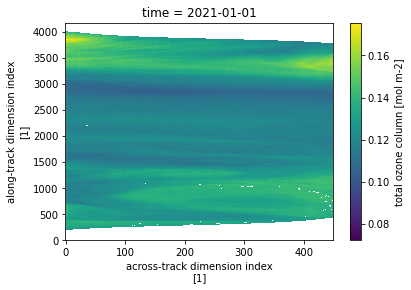

In [8]:
if 'CH4' in product:
    varname = 'methane_mixing_ratio'
elif 'NO2' in product:
    varname = 'nitrogendioxide_tropospheric_column'
elif 'O3' in product:
    varname = 'ozone_total_vertical_column'
elif 'CO' in product:
    varname = 'carbonmonoxide_total_column'
elif 'SO2' in product:
    varname = 'sulfurdioxide_total_vertical_column'
    
data = ds[varname][0,:,:]
data.plot();

### Extract values as numpy arrays

In [9]:
z = data.values
lon = ds['longitude'].values.squeeze()
lat = ds['latitude'].values.squeeze()

# Don't plot extreme latitudes; they make it hard to zoom in a nice way
minlat = -60; maxlat = 60

# Zoom to a sensible longitude area by plotting only values that are non-nan
# and above a threshold.
plot_threshold = np.nanpercentile(z,50)

valid_indices = np.argwhere((~np.isnan(z)) & (z > plot_threshold))

minlon = None; maxlon = None
for xy in valid_indices:
    xy_lon = lon[xy[0],xy[1]]
    xy_lat = lat[xy[0],xy[1]]
    if xy_lat > maxlat or xy_lat < minlat:
        continue
    if minlon is None or xy_lon < minlon:
        minlon = xy_lon
    if maxlon is None or xy_lon > maxlon:
        maxlon = xy_lon

plot_extent = (minlon, maxlon, minlat, maxlat)

### Plot on a basemap

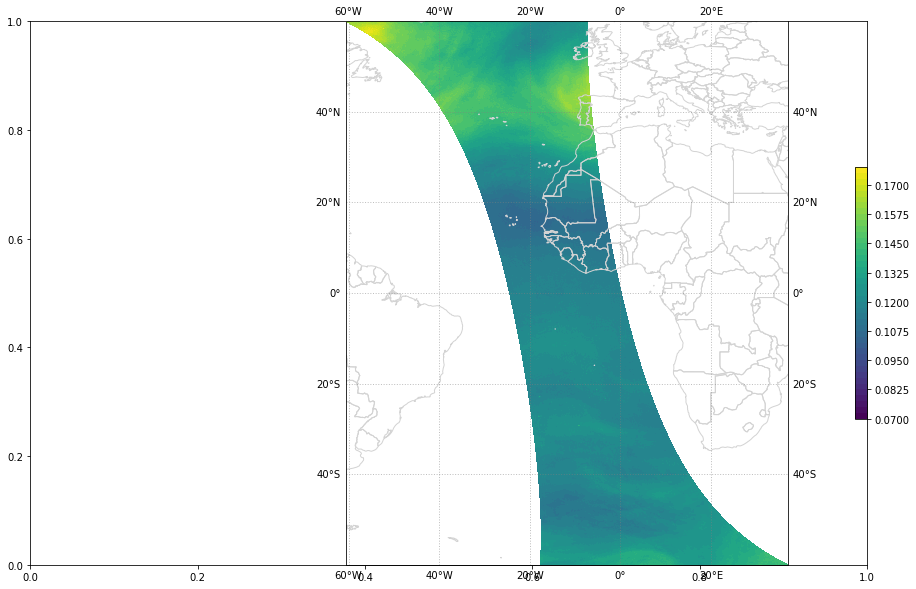

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature

figure, ax = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

# Prepare the background and axes
boundaries = cfeature.NaturalEarthFeature(
    category='cultural',name='admin_0_countries',scale='50m',facecolor='none')
ax.add_feature(boundaries, edgecolor='lightgray')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
ax.set_extent(plot_extent,ccrs.PlateCarree())

# Plot
plt.contourf(lon, lat, z, 50, transform=ccrs.PlateCarree())
plt.colorbar(fraction=0.015, pad=0.08)
plt.show()